In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib import animation

# Cellular Automata S.I.R. Model

### Description

Based on the reference [paper](https://www.math.uh.edu/~zpkilpat/teaching/math4309/project/physa99_fuentes.pdf), the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

### Assignments
1. Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model. 
2. Repeat point 1 several times in order to obtain several reference datasets
3. Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of 
4. Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

### Contacts
* Leonardo Badia <badia@dei.unipd.it>

MovieWriter ffmpeg unavailable; using Pillow instead.


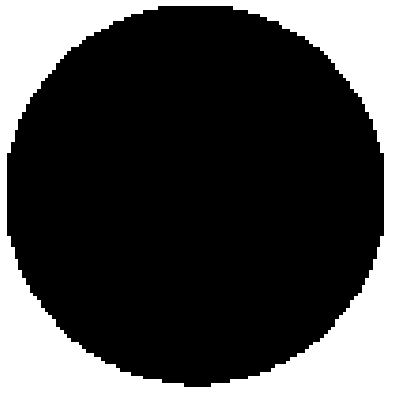

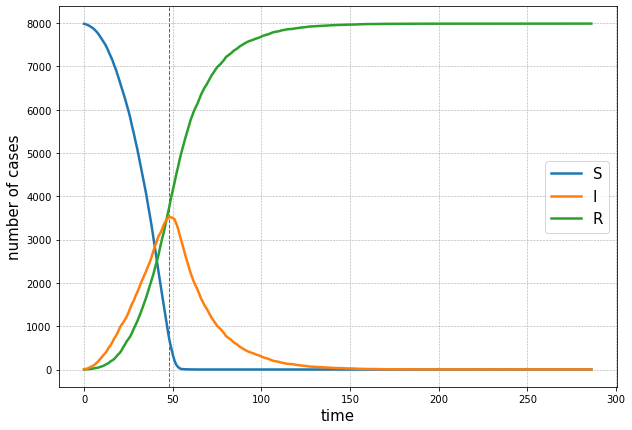

In [9]:
def draw_line(mat, point1, point2):
    
    # function that tries to draw the best possible line made of 0s between two points point1, point2
    
    x0, y0 = point1[0], point1[1];
    x1, y1 = point2[0], point2[1];
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 0
        return mat
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 0

    return mat if not transpose else mat.T

    
def new_population(N, n):
    
    # function that generates a new population. A population is a matrix NxN containing 2 everywhere except
    # inside a figure of n vertices where there are all 0s.
    
    from numpy import pi, floor, ceil, cos, sin;
    
    if n < 3: raise Exception('The number of vertices must be greater than 2.');
    
    if N%2 == 0: N+=1
        
    M = np.ones((N,N), dtype=int)+1 # matrix of 2s

    center = [floor(N/2), floor(N/2)]
    radius = floor(N/2)
    angle = 2*pi/n
    
    vertices = np.zeros((n+1,2), dtype=int)
    for vertex in range(n): # for each vertex of the polygon
        x = int(floor(center[0] + radius*cos(vertex*angle))) # x coord of the vertex of the polygon
        y = int(floor(center[1] - radius*sin(vertex*angle))) # y coord of the vertex of the polygon
        M[x,y] = 0 # set to 0 the coordinate of the population matrix
        vertices[vertex] = [x,y] # list of coordinates of the vertices of the polygon
    vertices[n] = vertices[0] # add the first vertex at the end so that is a closed polygon

    for i in range(1,len(vertices)):
        M = draw_line(M, vertices[i-1], vertices[i]) # trace the edges of the polygon
            
       
    for row in range(N): # the polygon is filled with 0s for each row
        row_i = M[row,:]   
        x1 = np.argwhere(M[row,:]==0)
        x2 = np.argwhere(M[row,:]==0)
        if len(x1)==0 or len(x2)==0: continue;
        x1, x2 = min(x1), max(x2)
        if x1==0 and x2==0: continue;
        M = draw_line(M, [row, x1], [row, x2])
          
    return M;

def change_status(indexes):
    
    # function that changes status to a person inside the matrix of population. From S to I and from I to R
    # (0 to 1 and 1 to -1).
    
    global population;

    if type(indexes)==tuple: indexes=[indexes] # if it's a tuple turn it into a list of tuples
    
    for index in indexes:
        status = population[index];   
        if status!=0 and status!=1 and status!=-1:
            raise Exception('status must be a number equal to -1, 0 or 1.'); 
            
        if status==0:
            population[index] = 1;
        elif status==1:
            population[index] = -1;

def neighbors(points):
    
    # function that returns a list of the coordinates of the Moore's neighbors of all the infected
    
    global population
    if type(points)==tuple: points=[points] # if it's a tuple turn it into a list of tuples
        
    neighbors_list = []    
    for point in points:
        x0, y0 = point[0], point[1]
        if not (0 <= x0 < population.shape[0] and 0 <= y0 < population.shape[1]):
            raise ValueError('Invalid coordinates.')

        mx = (x0 != population.shape[0]-1)+1 # if x0 is at the end of matrix the neighbors go from -1 to 0 otherwise 1
        my = (y0 != population.shape[1]-1)+1 # if y0 is at the end of matrix the neighbors go from -1 to 0 otherwise 1


        for i in range(-1,mx):
            for j in range (-1,my):
                if population[x0+i,y0+j]!=2 and not (i==0 and j==0) and (x0+i, y0+j) not in neighbors_list:
                    neighbors_list.append((x0+i, y0+j))
    return neighbors_list

def propagate(neighbors):
    
    # function that propagates the virus on the neighbors_list by changing the status of the neighbors with
    # some probability p_i (infection) and p_r (recovery).
    
    global population
    p_i = 0.5 # probability of infection
    p_r = 0.05 # probability of recovery
    
    for neighbor in neighbors:
        infection = np.random.choice([1, 0], p=[p_i, 1-p_i]) # infection yes/no with prob p_i
        if population[neighbor]==0 and infection:
            change_status(neighbor)
            
    for infected in infected_list():
        recovery = np.random.choice([1, 0], p=[p_r, 1-p_r]) # recovery yes/no with prob p_r
        if recovery: change_status(infected)
        
def infected_list():
    
    # function that return a list of coordinates of where the infected are
    
    global population
    return [tuple(coord) for coord in np.argwhere(population==1).tolist()]


####################################################################################################################


resolution, polygon_sides = 100, 50 # resolution is in reality the number of people inside the outward matrix
population = new_population(resolution, polygon_sides); # population is a matrix of 2 while 0 inside the figure

center = int(np.floor(resolution/2)) # just to keep track of where the center is

# 0 = S , 1 = I , -1 = R
infected = [(center,center)] # initialization of where Infected are. Can be tuple or list of tuples
change_status(infected) # the people located at "infected" are turned into infected: 0 -> 1

fig1 = plt.figure(figsize = (7,7));
plt.axis('off');
    
cycles=300 # maximum number of cycles   
images = []; S=[]; I=[]; R=[];
for cycle in range(cycles): 
    propagate(neighbors(infected)) # illness is propagated through the neighbors of the infected
    infected = infected_list() # the infected are now a different list from before
    
    im = plt.imshow(population, cmap='gray', vmin=-1, vmax=2, animated=True) # animation...
    images.append([im]) # animation...
    
    S.append(sum(sum(population==0))) # number of S in cycle i
    I.append(sum(sum(population==1))) # number of I in cycle i
    R.append(sum(sum(population==-1))) # number of R in cycle i

    if infected == []: break # If there are no more infected, end

ani = animation.ArtistAnimation(fig1, images, interval=1, blit=True, repeat_delay=1000) # animation...
ani.save('Propagation.gif') # animation...
plt.show() # animation...

# graph of the number of cases for each cycle
fig2 = plt.figure(figsize = (10,7))
plt.plot(S, label='S', zorder=10, linewidth=2.5);
plt.plot(I, label='I', zorder=20, linewidth=2.5);
plt.plot(R, label='R', zorder=10, linewidth=2.5);
plt.xlabel('time', fontsize=15);
plt.ylabel('number of cases', fontsize=15);
plt.legend(fontsize=15);
plt.grid(linestyle="--", linewidth=0.6, zorder=-10);
plt.axvline(x=np.argwhere(I==max(I)), linestyle='--', zorder=-5, linewidth=1);
#plt.xlim([0, cycles]);

